##  Loading all dependencies
Here we load all the libraries we will need for our first regression problem.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split


In [42]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

# 1  Linear regression 

## 1.1  Linear model 

### 1.1.1 Data generation
Here we generate some artificial data using a linear function and adding some noise to it.


In [43]:
def f_linear(x, m, b):
    return m * x + b

In [44]:
# number of points
npoints = 500

# noise parameter
dmax = 1

# interval
min_val = 0
max_val = 9

# slope and offset
m = 2.0
b = 5.00


In [45]:
# generate data 
x = np.linspace(min_val, max_val, npoints)
y = f_linear(x, m, b) + np.random.randn(npoints) * dmax
y_orig = f_linear(x, m, b)

# make the data two-dimensional (expected by the model)
x = x.reshape(-1,1)
y = y.reshape(-1,1)
y_orig = y_orig.reshape(-1,1)

Let's plot the data and have a look!

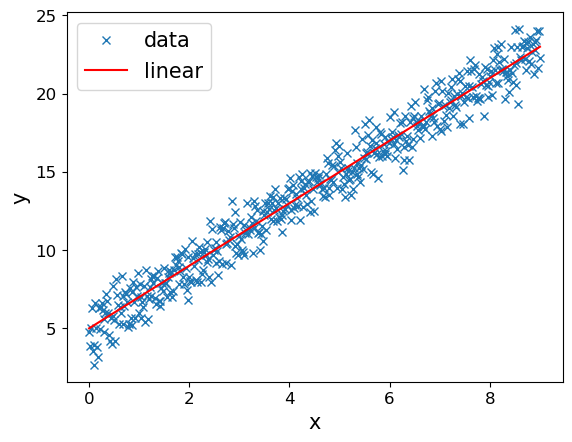

In [46]:
plt.plot(x,y, 'x', label = 'data')
plt.plot(x,y_orig,  label = 'linear',c="red")
plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



### 1.1.2  Datasets and DataLoaders


In [47]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index].float(), self.y[index].float()
  
  def __len__(self) -> int:
    return self.len

Now let's divide the full dataset into two smaller datasets for training and validation

In [48]:
# define fraction of data used for training
train_fraction = .8
n_train = int(train_fraction * npoints)

# get indices for training and test set
ids = np.arange(npoints)
np.random.shuffle(ids)
ids_train, ids_test  = np.split(ids, [n_train])

# generate datasets for training and testing        
train_data = Data(x[ids_train], y[ids_train])
test_data = Data(x[ids_test], y[ids_test])

In [49]:
print("The length of train data is:",len(train_data))
print("The length of test data is:",len(test_data))

The length of train data is: 400
The length of test data is: 100


In [50]:
batch_size = 16
trainloader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
testloader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

Let's plot training and validation data!

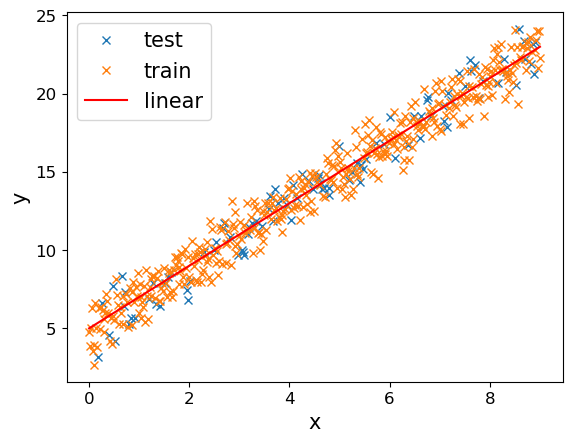

In [51]:
plt.plot(test_data.x,test_data.y, 'x', label = 'test')
plt.plot(train_data.x,train_data.y, 'x', label = 'train')
plt.plot(x, y_orig,  label = 'linear',c="red")
plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



### 1.1.3  Building and training a model

In [52]:
# fit the data with a linear regression model:
# y(w,x) = b + w1*x1 + w2*x2 + ... + wp*xp
# here we only fit b and w1, since we have 1D data
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(in_features=1,
                                      out_features=1,bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out

In [53]:
learningRate = 0.01 
n_epochs = 100

# generate a model and move it to the device
model = LinearRegression().to(DEVICE)

We can print the model to get some information.

In [54]:
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


Let's see how the untrained model performs!

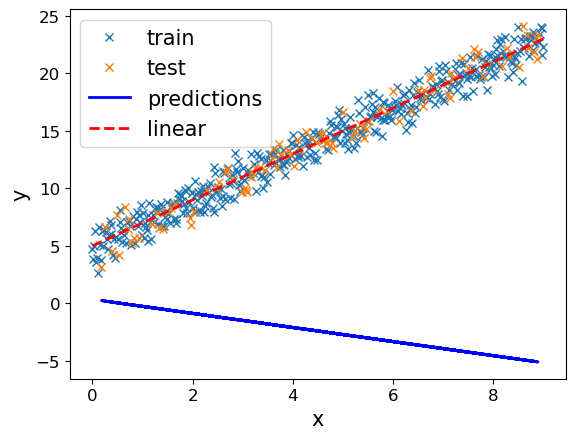

In [55]:
# Get model predictions for the test set
# we disable gradients because we are not in training mode here
# and get problems with numpy functions (used in the plotting routines)
with torch.no_grad():
    y_pred_test = model(test_data.x)

plt.plot(train_data.x ,train_data.y, 'x', label = 'train')
plt.plot(test_data.x, test_data.y, 'x', label = 'test')

# Plot the predicted data 
plt.plot(test_data.x, y_pred_test,c="blue", label = 'predictions',linewidth=2)
plt.plot(x,y_orig,  label = 'linear',c="red",linestyle="dashed",linewidth=2)
plt.legend(fontsize=15)

plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



In [56]:
print('R2 score = %8.5f' % r2_score(y_pred_test, test_data.y))


R2 score = -10.43023


In [57]:
# criterion to computes the loss between input and target
criterion = nn.MSELoss()

# optimizer that will be used to update weights and biases
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

This is how a standard training loop in pytorch looks like.

In [58]:
n_epochs = 1000
losses = np.empty(n_epochs)
n_log = 50

for epoch in range(n_epochs):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(trainloader):
    outputs = model(inputs)
    
    # compute loss
    loss = criterion(outputs, labels)   
    
    # set optimizer to zero grad to remove previous gradients
    optimizer.zero_grad()    # backward propagation
    
    # get gradients
    loss.backward()

    # gradient descent
    optimizer.step() 
    
    losses[epoch] = loss.item() # store loss

  if epoch % n_log == 0:
    print(f'Epochs:{epoch :5d} | ' \
          f'Loss: {loss :.10f}')

Epochs:    0 | Loss: 5.8980464935
Epochs:   50 | Loss: 2.1440324783


Epochs:  100 | Loss: 0.8732999563
Epochs:  150 | Loss: 1.2577731609
Epochs:  200 | Loss: 0.7754329443
Epochs:  250 | Loss: 1.2799034119
Epochs:  300 | Loss: 1.0935155153
Epochs:  350 | Loss: 0.9553917646
Epochs:  400 | Loss: 0.7023942471
Epochs:  450 | Loss: 0.6488757730
Epochs:  500 | Loss: 0.7373278737
Epochs:  550 | Loss: 1.0219732523
Epochs:  600 | Loss: 0.4767327905
Epochs:  650 | Loss: 0.9661558270
Epochs:  700 | Loss: 0.5954765081
Epochs:  750 | Loss: 0.7320139408
Epochs:  800 | Loss: 1.0880440474
Epochs:  850 | Loss: 1.2660849094
Epochs:  900 | Loss: 1.3114346266
Epochs:  950 | Loss: 1.2228499651


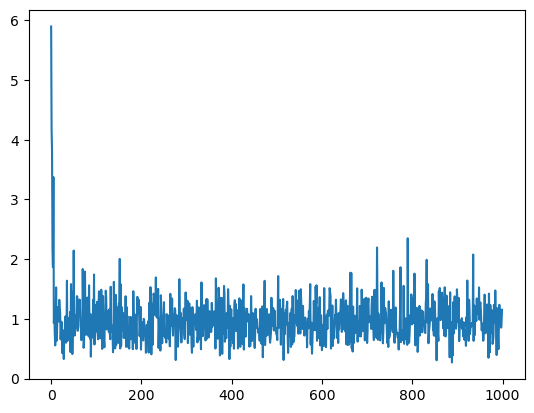

In [59]:
plt.plot(losses)
plt.show()

### 1.1.4  Model evaluation


In [60]:
# get predictions for training and test set
with torch.no_grad():
    y_pred_train = model(train_data.x)
    y_pred_test = model(test_data.x)


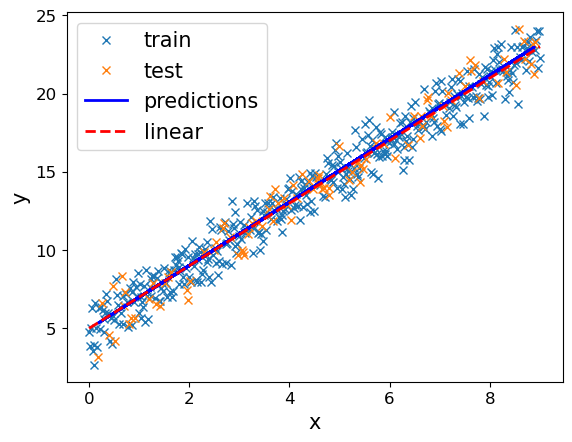

In [61]:
plt.plot(train_data.x ,train_data.y, 'x', label = 'train')
plt.plot(test_data.x, test_data.y, 'x', label = 'test')

# Plot the predicted data 
plt.plot(test_data.x, y_pred_test,c="blue", label = 'predictions',linewidth=2)
plt.plot(x,y_orig,  label = 'linear',c="red",linestyle="dashed",linewidth=2)
plt.legend(fontsize=15)

plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



In [62]:
mse_test = mean_squared_error(test_data.y,y_pred_test)
mse_train = mean_squared_error(train_data.y,y_pred_train)

mae_test = mean_absolute_error(test_data.y,y_pred_test)
mae_train = mean_absolute_error(train_data.y,y_pred_train)

print('MSE test  = %8.4f    MAE test  = %8.4f' % (mse_test,mae_test))
print('MSE train = %8.4f    MAE train = %8.4f' % (mse_train,mae_train))

MSE test  =   0.9758    MAE test  =   0.8054
MSE train =   0.9503    MAE train =   0.7967


In [63]:
print('R2 score = %8.5f' % r2_score(y_pred_test, test_data.y))


R2 score =  0.96535


Let's see what the parameters the model has learned. 

In [64]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print("Learned m:", layer.state_dict()['weight'])
        print("Learned b:", layer.state_dict()['bias'])
print("Exact m:", m)
print("Exact b:",b)

Learned m: tensor([[2.0253]])
Learned b: tensor([4.9679])
Exact m: 2.0
Exact b: 5.0


The learned parameters are quite close to the ones we used for generating the data!

## 1.2 Experiments

### 1.2.1 Different datasets

In [65]:
# Generate new data

In [66]:
# Make Datasets and DataLoaders with the new data


In [67]:
# Define a linear model and train


In [68]:
# make predictions and evaluate

### 1.2.2 Scaled data

In [69]:
class PTMinMaxScaler(object):
    """"Scaler class for min-max scaling."""
    def __init__(self, tensor, new_max, new_min):
        self.v_min, self.v_max = tensor.min(), tensor.max()
        self.new_max, self.new_min = new_max, new_min

    def scale(self, tensor):
        return (tensor - self.v_min)/(self.v_max - self.v_min)*(self.new_max - self.new_min) + self.new_min

    def inverse_scale(self, tensor):
        return (tensor - self.new_min) * (self.v_max - self.v_min)/(self.new_max - self.new_min) + self.v_min



In [70]:
# example usage of scaler class
x = np.linspace(-1,2, 5)

# fit the scaler
x_scaler = PTMinMaxScaler(x, 1. , 0.)
x_scaled = x_scaler.scale(x)

print(x,"\n", x_scaled,"\n", x_scaler.inverse_scale(x_scaled))

[-1.   -0.25  0.5   1.25  2.  ] 
 [0.   0.25 0.5  0.75 1.  ] 
 [-1.   -0.25  0.5   1.25  2.  ]


In [71]:
# scale the data and divide into training and test data


In [72]:
# check that we can invert 
# the scaling transformation to get back the original data

In [73]:
# Make a Dataset and DataLoader with the scaled data


In [74]:
# Define a linear model and train


In [75]:
# make predictions and evaluate
